<a href="https://colab.research.google.com/github/akshat-suwalka/Emotion-Recognition/blob/master/emotion_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import cv2
import numpy as np

dataset_path = 'fer2013.csv'
image_size=(48,48)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
data = pd.read_csv(dataset_path)
pixels = data['pixels'].tolist()
face = [int(pixel) for pixel in pixels[0].split(' ')]
face = np.asarray(face)
face = np.resize(face,48*48)
face = face.reshape(48, 48)
face = cv2.resize(face.astype('uint8'),image_size)
face = cv2.resize(face.astype('uint8'),image_size)
face = face.astype('float32')
face = np.asarray(face)
face = np.expand_dims(face, -1)

In [ ]:
def load_fer2013():
    data = pd.read_csv(dataset_path)
    pixels = data['pixels'].tolist()
    width, height = 48, 48
    faces = []
    for pixel_sequence in pixels:
        face = [int(pixel) for pixel in pixel_sequence.split(' ')]
        face = np.asarray(face)
        face = np.resize(face,48*48)
        face = face.reshape(width, height)
        face = cv2.resize(face.astype('uint8'),image_size)
        faces.append(face.astype('float32'))
    faces = np.asarray(faces)
    faces = np.expand_dims(faces, -1)
    emotions = pd.get_dummies(data['emotion']).as_matrix()
    return faces, emotions
 
def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    if v2:
        x = x - 0.5
        x = x * 2.0
    return x
 
faces, emotions = load_fer2013()
faces = preprocess_input(faces)
xtrain, xtest,ytrain,ytest = train_test_split(faces, emotions,test_size=0.2,shuffle=True)

In [ ]:
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2
import pandas as pd
import cv2
import numpy as np
import tensorflow as tf
 
# parameters
batch_size = 32
num_epochs = 110
input_shape = (48, 48, 1)
verbose = 1
num_classes = 7
patience = 50
base_path = r'C:\Users\Visitor\Downloads\Emotion-recognition-master\Emotion-recognition-master\models'
l2_regularization=0.01
 
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)
 
# model parameters
regularization = l2(l2_regularization)
 
# base
img_input = Input(input_shape)
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(img_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
 
# module 1
residual = Conv2D(16, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(16, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(16, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
 
# module 2
residual = Conv2D(32, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
 
# module 3
residual = Conv2D(64, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(64, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(64, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
 
# module 4
residual = Conv2D(128, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
x = Conv2D(num_classes, (3, 3), padding='same')(x)
x = GlobalAveragePooling2D()(x)

output = Activation('softmax',name='predictions')(x)
print(tf.shape(output))
model = Model(img_input, output)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()
 
# callbacks
log_file_path = base_path + '_emotion_training.log'
csv_logger = CSVLogger(log_file_path, append=False)
early_stop = EarlyStopping('val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1, patience=int(patience/4), verbose=1)
trained_models_path = base_path + '_mini_XCEPTION'
model_names = trained_models_path + '.{epoch:02d}-{val_acc:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,save_best_only=True)
callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]

model.fit_generator(data_generator.flow(xtrain, ytrain,batch_size),
                        steps_per_epoch=len(xtrain) / batch_size,
                        epochs=num_epochs, verbose=1, callbacks=callbacks,
                        validation_data=(xtest,ytest))

Tensor("Shape_2:0", shape=(2,), dtype=int32)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 46, 46, 8)    72          input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_29 (BatchNo (None, 46, 46, 8)    32          conv2d_15[0][0]                  
__________________________________________________________________________________________________
activation_13 (Activation)      (None, 46, 46, 8)    0           batch_normalization_29[0][0]     
_______________________________________________

<IPython.core.display.Javascript object>

<class 'numpy.ndarray'>


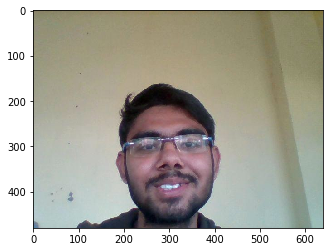

In [ ]:

from keras.models import load_model
import imutils
import cv2
import numpy as np
import os
import sys
import IPython
from IPython.display import HTML, Image
from google.colab.output import eval_js
import urllib
import html
from google.colab.patches import cv2_imshow
def take_photo(filename='photo.jpg', quality=0.8):
  js = IPython.display.Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  resp = urllib.request.urlopen(data)
  image = np.asarray(bytearray(resp.read()), dtype="uint8")
  image = cv2.imdecode(image, cv2.IMREAD_COLOR)
  # return the image
  return image

# to capture an image
img = take_photo()
print(type(img))

from PIL import Image
im = Image.fromarray(img)
im.save('y.jpeg')

%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(cv2.imread('y.jpeg'), interpolation='nearest')
plt.show()

1
<class 'numpy.ndarray'>
happy


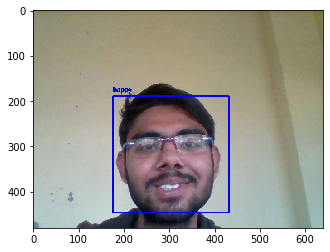

In [ ]:
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import imutils
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import sys
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
 
# parameters for loading data and images
detection_model_path = 'haarcascade_frontalface_default.xml'
emotion_model_path = 'fer2013_mini_XCEPTION.110-0.65.hdf5'

img_path = 'y.jpeg'
 
# hyper-parameters for bounding boxes shape
# loading models
face_detection = cv2.CascadeClassifier(detection_model_path)
emotion_classifier = load_model(emotion_model_path, compile=False)
#emotion_classifier = model
EMOTIONS = ["angry","disgust","scared", "happy", "sad", "surprised","neutral"]
 
#reading the frame
orig_frame = cv2.imread(img_path)
frame = cv2.imread(img_path,0)
faces = face_detection.detectMultiScale(frame,scaleFactor=1.1,minNeighbors=5,minSize=(30,30),flags=cv2.CASCADE_SCALE_IMAGE)

print(len(faces))
print(type(orig_frame))

if len(faces) > 0:
    faces = sorted(faces, reverse=True,key=lambda x: (x[2] - x[0]) * (x[3] - x[1]))[0]
    (fX, fY, fW, fH) = faces
    roi = frame[fY:fY + fH, fX:fX + fW]
    roi = cv2.resize(roi, (64, 64))
    roi = roi.astype("float") / 255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0)
    preds = emotion_classifier.predict(roi)[0]
    emotion_probability = np.max(preds)
    label = EMOTIONS[preds.argmax()]
    print(label)
    cv2.putText(orig_frame, label, (fX, fY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
    cv2.rectangle(orig_frame, (fX, fY), (fX + fW, fY + fH),(0, 0, 255), 2)




%matplotlib inline
plt.imshow(orig_frame, interpolation='nearest')
cv2.imwrite('test_output/'+img_path.split('/')[-1],orig_frame)
if (cv2.waitKey(2000) & 0xFF == ord('q')):
    sys.exit("Thanks")
cv2.destroyAllWindows()